# 이미지 증강 (10배) 및 전처리

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from os import listdir
from google.colab import drive

drive.mount('/content/drive')

path = "/content/drive/MyDrive/ml-class-rhseung/data/ai_car_박진재/"
directories = ['45deg/crop/', '90deg/crop/', '135deg/crop/']

Mounted at /content/drive


In [2]:
paths = [path + directory for directory in directories]
paths

['/content/drive/MyDrive/ml-class-rhseung/data/ai_car_박진재/45deg/crop/',
 '/content/drive/MyDrive/ml-class-rhseung/data/ai_car_박진재/90deg/crop/',
 '/content/drive/MyDrive/ml-class-rhseung/data/ai_car_박진재/135deg/crop/']

In [3]:
img_paths = [d_p + p for d_p in paths for p in listdir(d_p)]

len(img_paths)

320

In [4]:
img_paths[:5]

['/content/drive/MyDrive/ml-class-rhseung/data/ai_car_박진재/45deg/crop/train_crop_272.png',
 '/content/drive/MyDrive/ml-class-rhseung/data/ai_car_박진재/45deg/crop/train_crop_214.png',
 '/content/drive/MyDrive/ml-class-rhseung/data/ai_car_박진재/45deg/crop/train_crop.png',
 '/content/drive/MyDrive/ml-class-rhseung/data/ai_car_박진재/45deg/crop/train_crop_42.png',
 '/content/drive/MyDrive/ml-class-rhseung/data/ai_car_박진재/45deg/crop/train_crop_32.png']

In [5]:
from PIL import Image

img = Image.open(img_paths[0])
img_size = img.width, img.height

img_size

(160, 60)

In [6]:
import numpy as np

imgs = np.array([np.array(Image.open(p)) for p in img_paths])

imgs.shape

(320, 60, 160, 3)

In [7]:
r = imgs[:, :, :, 0]
g = imgs[:, :, :, 1]
b = imgs[:, :, :, 2]
channels = [r, g, b]

mean = [c.mean() for c in channels]
std = [c.std() for c in channels]

mean, std

([93.20895345052084, 100.4990283203125, 69.16825618489584],
 [49.419962975236494, 45.78133198620197, 49.848239584371825])

In [8]:
imgs[0]

array([[[ 98, 119, 132],
        [ 73,  94, 107],
        [ 72,  94, 107],
        ...,
        [ 54,  55,  26],
        [ 53,  54,  25],
        [ 53,  54,  25]],

       [[ 98, 119, 132],
        [ 72,  93, 106],
        [ 72,  94, 107],
        ...,
        [ 55,  56,  27],
        [ 54,  55,  26],
        [ 52,  53,  24]],

       [[ 97, 118, 131],
        [ 72,  93, 106],
        [ 72,  93, 106],
        ...,
        [ 55,  56,  27],
        [ 54,  55,  26],
        [ 53,  54,  25]],

       ...,

       [[ 58,  75,  57],
        [  5,  22,   4],
        [  4,  22,   6],
        ...,
        [132, 127, 110],
        [131, 126, 108],
        [131, 126, 108]],

       [[ 58,  75,  57],
        [  5,  22,   4],
        [  6,  23,   5],
        ...,
        [130, 128, 109],
        [132, 127, 109],
        [132, 127, 109]],

       [[ 58,  75,  57],
        [  5,  22,   4],
        [  9,  26,   8],
        ...,
        [131, 129, 110],
        [133, 128, 110],
        [133, 128, 110]]

In [9]:
x = np.array(Image.open(img_paths[0]))
# x = Image.open(img_paths[0])
# x = torch.Tensor(np.array(Image.open(img_paths[0])))

x.shape

(60, 160, 3)

In [10]:
x.transpose(2, 0, 1).shape

(3, 60, 160)

- `Compose` 객체는 `numpy.ndarray` 혹은 `torch.Tensor`를 인자로 받는데, `numpy.ndarray`는 사진으로 취급(채널이 뒤에)하고, `torch.Tensor`는 텐서로 취급(채널이 앞으로)한다.
- `ToTensor`는 `ToPILImage`를 거친 경우 모든 원소가 [0, 1]로 정규화됨

In [11]:
import torchvision.transforms as T

t = T.Compose([
    T.ToPILImage(),
    T.ToTensor()
])

composed = t(x)
print(composed.max(), composed.min())
print(composed.shape)

tensor(0.6863) tensor(0.0157)
torch.Size([3, 60, 160])


`ToPILImage`->`ToTensor` 를 거치면 [0, 1] 사이로 정규화하므로 mean, std 값을 [0, 1] 사이로 해야됨

In [12]:
import torchvision.transforms as T

# mean, std = [93.20895345052084, 100.4990283203125, 69.16825618489584], \
#  [49.41996297523648, 45.78133198620195, 49.8482395843718]
mean, std = [0.36552530764910146, 0.3941138365502449, 0.27124806347017993], \
 [0.19380377637347637, 0.17953463524000768, 0.1954832924877325]

transform = T.Compose([
    T.ToPILImage(),     # 얘는 채널을 맨 뒤에 받음
    T.ToTensor(),       # 얘를 거치면 채널이 맨 앞으로 옴
    T.Resize(img_size),
    T.RandomCrop(img_size, padding=6),
    T.Normalize(mean, std)
])

In [13]:
# 사진의 가로-세로 와 행렬의 행-열 순서가 반대라서 transpose를 조심해야함. 귀찮네

# fixme
transform(imgs[0].transpose(1, 2, 0)).numpy().transpose(0, 2, 1).shape

ValueError: ignored

In [14]:
classes = {
    '45': 0,
    '90': 1,
    '135': 2
}

In [17]:
imgs[0].shape

(60, 160, 3)

In [18]:
X = []
Y = []

for path, img in zip(img_paths, imgs):
    y = classes[path.split('/')[-3][:-3]]

    if y == 0 or y == 2:
        mul = 30
    else:
        mul = 10

    for _ in range(mul):
        X.append(transform(img).numpy())
        Y.append(y)

X = np.array(X)
Y = np.array(Y)

X.shape, Y.shape

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


((5960, 3, 160, 60), (5960,))

In [19]:
Y

array([0, 0, 0, ..., 2, 2, 2])

(array([1980.,    0.,    0.,    0.,    0., 1820.,    0.,    0.,    0.,
        2160.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

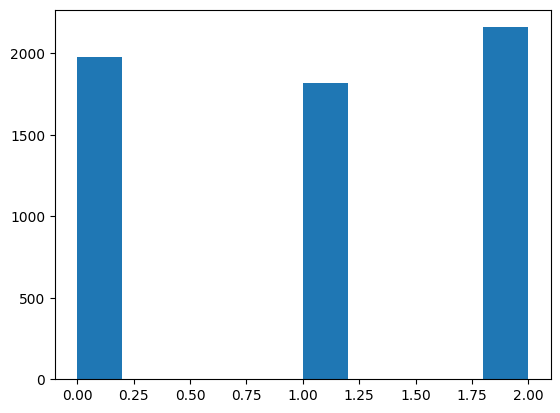

In [20]:
import matplotlib.pyplot as plt

plt.hist(Y)

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_, Y_train, Y_ = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=224)
X_valid, X_test, Y_valid, Y_test = train_test_split(X_, Y_, test_size=0.5, stratify=Y_, random_state=224)

print(X_train.shape, X_valid.shape, X_test.shape)
print(Y_train.shape, Y_valid.shape, Y_test.shape)

(4768, 3, 160, 60) (596, 3, 160, 60) (596, 3, 160, 60)
(4768,) (596,) (596,)


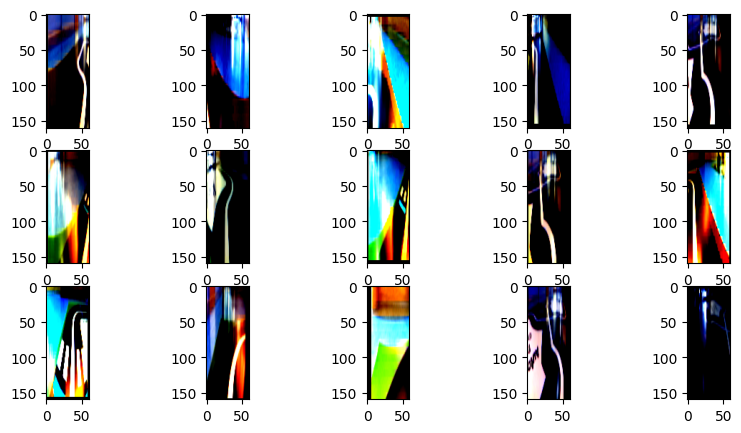

In [22]:
fig, ax = plt.subplots(3, 5, figsize=(10, 5))

for i in range(ax.shape[0]):
    indices = np.where(Y_train == i)[0]

    for j in range(ax.shape[1]):
        ax[i, j].imshow(X_train[indices[j]].transpose(1, 2, 0))

In [23]:
X_train[0].shape

(3, 160, 60)

In [24]:
X_train[0].max(), X_train[0].min()

(3.5457306, -2.1951969)

In [25]:
np.save("/content/drive/MyDrive/ml-class-rhseung/numpy/X_train", X_train)
np.save("/content/drive/MyDrive/ml-class-rhseung/numpy/X_valid", X_valid)
np.save("/content/drive/MyDrive/ml-class-rhseung/numpy/X_test", X_test)
np.save("/content/drive/MyDrive/ml-class-rhseung/numpy/Y_train", Y_train)
np.save("/content/drive/MyDrive/ml-class-rhseung/numpy/Y_valid", Y_valid)
np.save("/content/drive/MyDrive/ml-class-rhseung/numpy/Y_test", Y_test)

KeyboardInterrupt: ignored

# 데이터 불러오기

In [ ]:
import numpy as np
from os import listdir

X_train = np.load("/content/drive/MyDrive/ml-class-rhseung/numpy/X_train.npy")
X_valid = np.load("/content/drive/MyDrive/ml-class-rhseung/numpy/X_valid.npy")
X_test = np.load("/content/drive/MyDrive/ml-class-rhseung/numpy/X_test.npy")

Y_train = np.load("/content/drive/MyDrive/ml-class-rhseung/numpy/Y_train.npy")
Y_valid = np.load("/content/drive/MyDrive/ml-class-rhseung/numpy/Y_valid.npy")
Y_test = np.load("/content/drive/MyDrive/ml-class-rhseung/numpy/Y_test.npy")

print(X_train.shape, X_valid.shape, X_test.shape)
print(Y_train.shape, Y_valid.shape, Y_test.shape)

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cuda')

In [27]:
class RobotDataset(Dataset):
    def __init__(self, X: np.ndarray, Y: np.ndarray, device='cpu', transform=None):
        self.X_ = X
        self.X = torch.FloatTensor(X).to(device)
        self.Y = torch.LongTensor(Y).to(device)
        self.transform = transform

    def __len__(self):
        assert len(self.X) == len(self.Y)
        return len(self.Y)

    def __getitem__(self, idx: int):
        if self.transform is not None:
            # transform 에 넣으려면 채널이 맨 마지막 차원에 존재해야됨.
            # transform은 인자로 Pillow Image(혹은 같은 취급을 받는 numpy)를 받는데,
            # Pillow Image는 각 픽셀에 (r, g, b) 튜플을 지니기 때문에 마지막 차원이 채널임

            return self.transform(self.X_[idx].transpose(1, 2, 0)), self.Y[idx]
        else:
            return self.X[idx], self.Y[idx]

train_set = RobotDataset(X_train, Y_train, device)
valid_set = RobotDataset(X_valid, Y_valid, device)
test_set = RobotDataset(X_test, Y_test, device)

In [28]:
batch_size = 32

train_loader = DataLoader(train_set, drop_last=True, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, drop_last=True, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, drop_last=True, batch_size=batch_size, shuffle=True)

len(train_loader)

149

In [29]:
for x, y in train_loader:
    print(x.dtype)
    print(x.float().dtype)
    print(y.shape)
    break

torch.float32
torch.float32
torch.Size([32])


# 모델 구성 및 훈련

In [30]:
import torch.nn as nn

class Block(nn.Module):
    def __init__(self, in_channels, hidden, out_channels):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, hidden, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(hidden, out_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.layers = [
            self.conv1,
            self.conv2,
            self.relu,
            self.pool
        ]

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)

        return x

class Net(nn.Module):
    def __init__(self, num_classes: int):
        super().__init__()

        self.block1 = Block(3, 16, 32)      # (3, 60, 160) -> (32, 30, 80)
        self.block2 = Block(32, 48, 64)     # (32, 30, 80) -> (64, 15, 40)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten(1)
        self.fc1 = nn.Linear(64*15*40, 16*15)
        self.fc2 = nn.Linear(16*15, num_classes)

        self.layers = [
            self.block1,
            self.block2,
            self.flatten,
            self.fc1,
            self.relu,
            self.fc2
        ]

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)

        return x

In [31]:
from torchsummary import summary

model = Net(len(classes)).to(device)
summary(model, (3, 60, 160))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 16, 60, 160]             448
            Conv2d-2          [-1, 32, 60, 160]           4,640
              ReLU-3          [-1, 32, 60, 160]               0
         MaxPool2d-4           [-1, 32, 30, 80]               0
             Block-5           [-1, 32, 30, 80]               0
            Conv2d-6           [-1, 48, 30, 80]          13,872
            Conv2d-7           [-1, 64, 30, 80]          27,712
              ReLU-8           [-1, 64, 30, 80]               0
         MaxPool2d-9           [-1, 64, 15, 40]               0
            Block-10           [-1, 64, 15, 40]               0
          Flatten-11                [-1, 38400]               0
           Linear-12                  [-1, 240]       9,216,240
             ReLU-13                  [-1, 240]               0
           Linear-14                   

In [32]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=1e-3)
cost = nn.CrossEntropyLoss().to(device)

In [33]:
from tqdm import tqdm
from dataclasses import dataclass
from math import inf

@dataclass
class Epoch:
    idx: int = None
    valid_loss: float = inf
    model_state: dict = None

before, curr = Epoch(), Epoch()
best = Epoch()

overfit_streak = 0
patience = 5

epochs = 100

for epoch in range(epochs):
    print(f'Epoch {epoch + 1}\n-------------------------')

    with tqdm(train_loader, unit='batch') as train:
        train.set_description("train")
        train_loss = 0

        for x, y in train:
            pred = model(x)
            loss = cost(pred, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() / len(train)
            train.set_postfix(loss=train_loss)

    with torch.no_grad():
        with tqdm(valid_loader, unit='batch') as valid:
            valid.set_description("valid")
            valid_loss = 0

            for x, y in valid:
                pred = model(x)
                loss = cost(pred, y)

                valid_loss += loss.item() / len(valid)
                valid.set_postfix(loss=valid_loss)

    curr = Epoch(epoch, valid_loss, model.state_dict())

    if curr.valid_loss >= best.valid_loss:
        overfit_streak += 1
        print(f'overfit {overfit_streak}')
    else:
        overfit_streak = 0
        best = curr

    if patience <= overfit_streak:
        print(f"Early Stopping, best model is {best.idx + 1} epoch")
        break

    before = curr
    print()

torch.save(best.model_state, 'best_model.pth')

Epoch 1
-------------------------


valid: 100%|██████████| 18/18 [00:00<00:00, 148.34batch/s, loss=0.54]



Epoch 2
-------------------------


valid: 100%|██████████| 18/18 [00:00<00:00, 131.10batch/s, loss=0.399]



Epoch 3
-------------------------


valid: 100%|██████████| 18/18 [00:00<00:00, 150.30batch/s, loss=0.343]



Epoch 4
-------------------------


valid: 100%|██████████| 18/18 [00:00<00:00, 162.07batch/s, loss=0.249]



Epoch 5
-------------------------


valid: 100%|██████████| 18/18 [00:00<00:00, 151.13batch/s, loss=0.168]



Epoch 6
-------------------------


valid: 100%|██████████| 18/18 [00:00<00:00, 118.65batch/s, loss=0.196]


overfit 1

Epoch 7
-------------------------


valid: 100%|██████████| 18/18 [00:00<00:00, 150.82batch/s, loss=0.17]


overfit 2

Epoch 8
-------------------------


valid: 100%|██████████| 18/18 [00:00<00:00, 134.18batch/s, loss=0.262]


overfit 3

Epoch 9
-------------------------


valid: 100%|██████████| 18/18 [00:00<00:00, 159.35batch/s, loss=0.227]


overfit 4

Epoch 10
-------------------------


valid: 100%|██████████| 18/18 [00:00<00:00, 148.27batch/s, loss=0.151]



Epoch 11
-------------------------


valid: 100%|██████████| 18/18 [00:00<00:00, 150.23batch/s, loss=0.175]


overfit 1

Epoch 12
-------------------------


valid: 100%|██████████| 18/18 [00:00<00:00, 133.14batch/s, loss=0.148]



Epoch 13
-------------------------


valid: 100%|██████████| 18/18 [00:00<00:00, 54.93batch/s, loss=0.146]



Epoch 14
-------------------------


valid: 100%|██████████| 18/18 [00:00<00:00, 150.60batch/s, loss=0.112]



Epoch 15
-------------------------


valid: 100%|██████████| 18/18 [00:00<00:00, 145.47batch/s, loss=0.185]


overfit 1

Epoch 16
-------------------------


valid: 100%|██████████| 18/18 [00:00<00:00, 149.86batch/s, loss=0.0969]



Epoch 17
-------------------------


valid: 100%|██████████| 18/18 [00:00<00:00, 116.96batch/s, loss=0.253]


overfit 1

Epoch 18
-------------------------


valid: 100%|██████████| 18/18 [00:00<00:00, 134.28batch/s, loss=0.178]


overfit 2

Epoch 19
-------------------------


valid: 100%|██████████| 18/18 [00:00<00:00, 128.24batch/s, loss=0.183]


overfit 3

Epoch 20
-------------------------


valid: 100%|██████████| 18/18 [00:00<00:00, 153.38batch/s, loss=0.153]


overfit 4

Epoch 21
-------------------------


valid: 100%|██████████| 18/18 [00:00<00:00, 152.36batch/s, loss=0.175]


overfit 5
Early Stopping, best model is 16 epoch


In [34]:
best.idx, best.valid_loss

(15, 0.09690110534170848)

In [35]:
model = Net(len(classes)).to(device)
model.load_state_dict(torch.load('best_model.pth', map_location=device))

if not isinstance(X_test, torch.Tensor):
    X_test = torch.FloatTensor(X_test).to(device)
    Y_test = torch.LongTensor(Y_test).to(device)

with torch.no_grad():
    output = model(X_test)
    pred = output.argmax(dim=1)
    is_correct = pred == Y_test

    print(f'Accuracy: {float(is_correct.float().mean())}')

Accuracy: 0.9697986841201782


# 모델 개선

In [ ]:
import torch.nn as nn

class Block2(nn.Module):
    def __init__(self, in_channels, hidden, out_channels):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, hidden, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(hidden)           # 배치 정규화
        self.conv2 = nn.Conv2d(hidden, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)     # 배치 정규화
        self.downsample = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.dropout = nn.Dropout(p=0.5)            # 드롭 아웃 추가
        self.relu = nn.LeakyReLU()                  # ReLU 대신 LeakyReLU 사용, 기본값 negative_slope=0.01
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x_ = x

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x_ = self.downsample(x_)
        x = x + x_      # 스킵 커넥션
        x = self.relu(x)

        x = self.dropout(x)
        x = self.pool(x)

        return x

class Net2(nn.Module):
    def __init__(self, num_classes: int):
        super().__init__()

        self.block1 = Block2(3, 16, 32)      # (3, 60, 160) -> (32, 30, 80)
        self.block2 = Block2(32, 48, 64)     # (32, 30, 80) -> (64, 15, 40)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten(1)
        self.fc1 = nn.Linear(64*15*40, 16*15)
        self.fc2 = nn.Linear(16*15, num_classes)

        self.layers = [
            self.block1,
            self.block2,
            self.flatten,
            self.fc1,
            self.relu,
            self.fc2
        ]

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)

        return x

In [ ]:
from torchsummary import summary

model = Net2(len(classes)).to(device)
summary(model, (3, 60, 160))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 16, 60, 160]             448
       BatchNorm2d-2          [-1, 16, 60, 160]              32
         LeakyReLU-3          [-1, 16, 60, 160]               0
            Conv2d-4          [-1, 32, 60, 160]           4,640
       BatchNorm2d-5          [-1, 32, 60, 160]              64
            Conv2d-6          [-1, 32, 60, 160]             128
         LeakyReLU-7          [-1, 32, 60, 160]               0
           Dropout-8          [-1, 32, 60, 160]               0
         MaxPool2d-9           [-1, 32, 30, 80]               0
           Block2-10           [-1, 32, 30, 80]               0
           Conv2d-11           [-1, 48, 30, 80]          13,872
      BatchNorm2d-12           [-1, 48, 30, 80]              96
        LeakyReLU-13           [-1, 48, 30, 80]               0
           Conv2d-14           [-1, 64,

In [ ]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=1e-4)     # lr을 1e-4 로 수정
cost = nn.CrossEntropyLoss().to(device)

In [ ]:
from tqdm import tqdm
from dataclasses import dataclass
from math import inf

@dataclass
class Epoch:
    idx: int = None
    valid_loss: float = inf
    model_state: dict = None

before, curr = Epoch(), Epoch()
best = Epoch()

overfit_streak = 0
patience = 10   # patience도 늘려줌

epochs = 100

for epoch in range(epochs):
    print(f'Epoch {epoch + 1}\n-------------------------')

    with tqdm(train_loader, unit='batch') as train:
        train.set_description("train")
        train_loss = 0

        for x, y in train:
            pred = model(x)
            loss = cost(pred, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() / len(train)
            train.set_postfix(loss=train_loss)

    with torch.no_grad():
        with tqdm(valid_loader, unit='batch') as valid:
            valid.set_description("valid")
            valid_loss = 0

            for x, y in valid:
                pred = model(x)
                loss = cost(pred, y)

                valid_loss += loss.item() / len(valid)
                valid.set_postfix(loss=valid_loss)

    curr = Epoch(epoch, valid_loss, model.state_dict())

    if curr.valid_loss >= best.valid_loss:
        overfit_streak += 1
        print(f'overfit {overfit_streak}')
    else:
        overfit_streak = 0
        best = curr

    if patience <= overfit_streak:
        print(f"Early Stopping, best model is {best.idx + 1} epoch")
        break

    before = curr
    print()

torch.save(best.model_state, 'best_model2.pth')

Epoch 1
-------------------------


valid: 100%|██████████| 18/18 [00:00<00:00, 141.41batch/s, loss=0.592]



Epoch 2
-------------------------


valid: 100%|██████████| 18/18 [00:00<00:00, 146.09batch/s, loss=0.415]



Epoch 3
-------------------------


valid: 100%|██████████| 18/18 [00:00<00:00, 168.25batch/s, loss=0.445]


overfit 1

Epoch 4
-------------------------


valid: 100%|██████████| 18/18 [00:00<00:00, 183.31batch/s, loss=0.34]



Epoch 5
-------------------------


valid: 100%|██████████| 18/18 [00:00<00:00, 186.91batch/s, loss=0.374]


overfit 1

Epoch 6
-------------------------


valid: 100%|██████████| 18/18 [00:00<00:00, 174.11batch/s, loss=0.243]



Epoch 7
-------------------------


valid: 100%|██████████| 18/18 [00:00<00:00, 177.53batch/s, loss=0.263]


overfit 1

Epoch 8
-------------------------


valid: 100%|██████████| 18/18 [00:00<00:00, 158.61batch/s, loss=0.242]



Epoch 9
-------------------------


valid: 100%|██████████| 18/18 [00:00<00:00, 143.83batch/s, loss=0.255]


overfit 1

Epoch 10
-------------------------


valid: 100%|██████████| 18/18 [00:00<00:00, 141.59batch/s, loss=0.185]



Epoch 11
-------------------------


valid: 100%|██████████| 18/18 [00:00<00:00, 171.36batch/s, loss=0.184]



Epoch 12
-------------------------


valid: 100%|██████████| 18/18 [00:00<00:00, 183.55batch/s, loss=0.231]


overfit 1

Epoch 13
-------------------------


valid: 100%|██████████| 18/18 [00:00<00:00, 172.00batch/s, loss=0.227]


overfit 2

Epoch 14
-------------------------


valid: 100%|██████████| 18/18 [00:00<00:00, 183.22batch/s, loss=0.186]


overfit 3

Epoch 15
-------------------------


valid: 100%|██████████| 18/18 [00:00<00:00, 168.42batch/s, loss=0.289]


overfit 4

Epoch 16
-------------------------


valid: 100%|██████████| 18/18 [00:00<00:00, 162.03batch/s, loss=0.226]


overfit 5

Epoch 17
-------------------------


valid: 100%|██████████| 18/18 [00:00<00:00, 168.48batch/s, loss=0.35]


overfit 6

Epoch 18
-------------------------


valid: 100%|██████████| 18/18 [00:00<00:00, 165.53batch/s, loss=0.199]


overfit 7

Epoch 19
-------------------------


valid: 100%|██████████| 18/18 [00:00<00:00, 182.02batch/s, loss=0.256]


overfit 8

Epoch 20
-------------------------


valid: 100%|██████████| 18/18 [00:00<00:00, 181.82batch/s, loss=0.222]


overfit 9

Epoch 21
-------------------------


valid: 100%|██████████| 18/18 [00:00<00:00, 173.80batch/s, loss=0.257]


overfit 10
Early Stopping, best model is 11 epoch


In [ ]:
best.idx, best.valid_loss

(10, 0.18414999275571772)

In [ ]:
model = Net2(len(classes)).to(device)
model.load_state_dict(torch.load('best_model2.pth', map_location=device))

if not isinstance(X_test, torch.Tensor):
    X_test = torch.FloatTensor(X_test).to(device)
    Y_test = torch.LongTensor(Y_test).to(device)

with torch.no_grad():
    output = model(X_test)
    pred = output.argmax(dim=1)
    is_correct = pred == Y_test

    print(f'Accuracy: {float(is_correct.float().mean())}')

Accuracy: 0.9446308612823486


# 전이 학습

In [ ]:
img_size2 = (224, 224)

transform_to_vgg = T.Compose([
    T.ToTensor(),
    T.Resize(img_size2),
    # T.RandomCrop(img_size2, padding=4),
    # T.Normalize(mean, std)
])

In [ ]:
train_set = RobotDataset(X_train, Y_train, device, transform_to_vgg)
valid_set = RobotDataset(X_valid, Y_valid, device, transform_to_vgg)
# test_set = RobotDataset(X_test, Y_test, device, transform_to_vgg)

In [ ]:
batch_size = 32

train_loader = DataLoader(train_set, drop_last=True, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, drop_last=True, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, drop_last=True, batch_size=batch_size, shuffle=True)

len(train_loader)

149

In [ ]:
from torchvision.models.vgg import vgg16
import torch.nn as nn

model = vgg16(pretrained=True).to(device)
model.classifier = nn.Sequential(
    nn.Linear(7*7*512, 7*512),
    nn.ReLU(),
    nn.Dropout(p=0.5),

    nn.Linear(7*512, 512),
    nn.ReLU(),
    nn.Dropout(p=0.5),

    nn.Linear(512, len(classes))
).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:14<00:00, 38.4MB/s]


In [ ]:
from torchsummary import summary

summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [ ]:
import torch.optim as optim

cost = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
for x, y in train_loader:
    print(x.dtype)
    print(x.float().dtype)
    print(model(x.float().to(device)).shape)
    print(y.shape)
    break

torch.float64
torch.float32
torch.Size([32, 3])
torch.Size([32])


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [ ]:
from tqdm import tqdm
from dataclasses import dataclass
from math import inf

@dataclass
class Epoch:
    idx: int = None
    valid_loss: float = inf
    model_state: dict = None

before, curr = Epoch(), Epoch()
best = Epoch()

overfit_streak = 0
patience = 8

epochs = 30

for epoch in range(epochs):
    print(f'Epoch {epoch + 1}\n-------------------------')

    with tqdm(train_loader, unit='batch') as train:
        train.set_description("train")
        train_loss = 0

        for x, y in train:
            x = x.float().to(device)    # Input type (double) and bias type (float) should be the same 오류 때문에

            pred = model(x)
            loss = cost(pred, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() / len(train)
            train.set_postfix(loss=train_loss)

    with torch.no_grad():
        with tqdm(valid_loader, unit='batch') as valid:
            valid.set_description("valid")
            valid_loss = 0

            for x, y in valid:
                x = x.float().to(device)    # Input type (double) and bias type (float) should be the same 오류 때문에

                pred = model(x)
                loss = cost(pred, y)

                valid_loss += loss.item() / len(valid)
                valid.set_postfix(loss=valid_loss)

    curr = Epoch(epoch, valid_loss, model.state_dict())

    if curr.valid_loss >= best.valid_loss:
        overfit_streak += 1
        print(f'overfit {overfit_streak}')
    else:
        overfit_streak = 0
        best = curr

    if patience <= overfit_streak:
        print(f"Early Stopping, best model is {best.idx + 1} epoch")
        break

    before = curr
    print()

torch.save(best.model_state, 'best_model3.pth')

Epoch 1
-------------------------


valid: 100%|██████████| 18/18 [00:02<00:00,  6.57batch/s, loss=0.36]



Epoch 2
-------------------------


valid: 100%|██████████| 18/18 [00:02<00:00,  8.00batch/s, loss=0.197]



Epoch 3
-------------------------


valid: 100%|██████████| 18/18 [00:02<00:00,  7.91batch/s, loss=0.0688]



Epoch 4
-------------------------


valid: 100%|██████████| 18/18 [00:02<00:00,  7.24batch/s, loss=0.0644]



Epoch 5
-------------------------


valid: 100%|██████████| 18/18 [00:02<00:00,  7.73batch/s, loss=0.0683]


overfit 1

Epoch 6
-------------------------


valid: 100%|██████████| 18/18 [00:02<00:00,  8.00batch/s, loss=0.00619]



Epoch 7
-------------------------


valid: 100%|██████████| 18/18 [00:02<00:00,  7.47batch/s, loss=0.052]


overfit 1

Epoch 8
-------------------------


valid: 100%|██████████| 18/18 [00:02<00:00,  7.40batch/s, loss=0.0177]


overfit 2

Epoch 9
-------------------------


valid: 100%|██████████| 18/18 [00:02<00:00,  7.85batch/s, loss=0.000917]



Epoch 10
-------------------------


valid: 100%|██████████| 18/18 [00:02<00:00,  7.93batch/s, loss=0.000989]


overfit 1

Epoch 11
-------------------------


valid: 100%|██████████| 18/18 [00:02<00:00,  7.00batch/s, loss=0.000741]



Epoch 12
-------------------------


valid: 100%|██████████| 18/18 [00:02<00:00,  8.06batch/s, loss=0.000244]



Epoch 13
-------------------------


valid: 100%|██████████| 18/18 [00:02<00:00,  7.99batch/s, loss=0.000629]


overfit 1

Epoch 14
-------------------------


valid: 100%|██████████| 18/18 [00:02<00:00,  6.47batch/s, loss=0.000189]



Epoch 15
-------------------------


valid: 100%|██████████| 18/18 [00:02<00:00,  7.84batch/s, loss=0.000336]


overfit 1

Epoch 16
-------------------------


valid: 100%|██████████| 18/18 [00:02<00:00,  8.05batch/s, loss=0.000306]


overfit 2

Epoch 17
-------------------------


valid: 100%|██████████| 18/18 [00:02<00:00,  6.56batch/s, loss=0.000573]


overfit 3

Epoch 18
-------------------------


valid: 100%|██████████| 18/18 [00:02<00:00,  7.97batch/s, loss=0.0027]


overfit 4

Epoch 19
-------------------------


valid: 100%|██████████| 18/18 [00:02<00:00,  7.84batch/s, loss=0.00116]


overfit 5

Epoch 20
-------------------------


valid: 100%|██████████| 18/18 [00:04<00:00,  3.97batch/s, loss=0.000911]


overfit 6

Epoch 21
-------------------------


valid: 100%|██████████| 18/18 [00:02<00:00,  7.88batch/s, loss=0.000299]


overfit 7

Epoch 22
-------------------------


valid: 100%|██████████| 18/18 [00:02<00:00,  7.93batch/s, loss=0.000797]


overfit 8
Early Stopping, best model is 14 epoch


In [ ]:
best.idx, best.valid_loss

(13, 0.0001892927854546163)

`valid_loss`는 다른 모델들의 결과에 비해 압도적으로 적은데 정확도가...?
negative transfer 라는 현상이라고 함

In [ ]:
# model = vgg16().to(device)
model.load_state_dict(torch.load('best_model3.pth', map_location=device))

if not isinstance(X_test, torch.Tensor):
    X_test = torch.FloatTensor(X_test).to(device)
    Y_test = torch.LongTensor(Y_test).to(device)

with torch.no_grad():
    output = model(X_test)
    pred = output.argmax(dim=1)
    is_correct = pred == Y_test

    print(f'Accuracy: {float(is_correct.float().mean())}')

Accuracy: 0.3691275119781494
